In [1]:
# scientific libraries
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from skimage import io

# general libraries
import os  
import json
import time
import h5py as h5py
import copy

# jupyter imports
import ipywidgets as widgets
from IPython.display import clear_output

# local libraries
from analysis import *
from general_utils import *
from hdf_utils import unpack_hdf, Workspace
from scalebars import *
import deconv

import sac_mode_configs as configs
import experiments as exps
import analysis as ana
from interactive import MotionResponse

In [2]:
%matplotlib widget
plt.rcParams.update({"figure.max_open_warning": 0})
plt.rcParams['svg.fonttype'] = 'none'  # don't save font as paths (assumes font present on machine)

In [3]:
base_path = "/mnt/Data/NEURONoutput/sac_net/"

In [4]:
titration_path = os.path.join(base_path, "gaba_titration")
fig_path = os.path.join(base_path, "erm2023_figs") 

ctrl_name = "ctrl_5ms_step_weight_x2_order2_6n_3tr_0p0_5p0"
expr_name = "plex3_5ms_step_weight_x2_order2_6n_3tr_0p0_5p0"

ctrl_lbl = "ctrl"
expr_lbl = "plex"

ctrl_hdf = h5.File(os.path.join(titration_path, ctrl_name) + ".h5", "r")
ctrl = Workspace(ctrl_hdf, read_only=True)
expr_hdf = h5.File(os.path.join(titration_path, expr_name) + ".h5", "r")
expr = Workspace(expr_hdf, read_only=True)
d = {ctrl_lbl: ctrl, expr_lbl: expr}
os.makedirs(fig_path, exist_ok=True)

exps = list(d.keys())
factors = list(ctrl.keys())
rhos = list(ctrl[factors[0]].keys())
idxs = list(ctrl[factors[0]][rhos[0]].keys())
print("==keys==")
print("exps:", exps)
print("factors:", factors)
print("rhos:", rhos)
print("idxs:", idxs)

==keys==
exps: ['ctrl', 'plex']
factors: [0.0, 0.025, 0.05, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 3.0, 4.0, 5.0]
rhos: [0.0, 1.0]
idxs: [0, 1, 2, 3, 4, 5]


In [5]:
def close_button():
    button = widgets.Button(description="Close Workspace")
    out = widgets.Output()

    def on_clicked(_):
        with out:
            clear_output()
            for wrk in d.values():
                wrk.close()
            print("File closed!")
        
    button.on_click(on_clicked)
    return widgets.VBox([button, out])

close_button()

In [6]:
metrics = {exp: {k: ana.get_sac_metrics(wrk[k]) for k in factors} for exp, wrk in d.items()}

dir_labels = d["ctrl"][factors[0]][rhos[0]][idxs[0]]["params"]["dir_labels"][:]
sac_thetas = {exp: ana.get_sac_thetas(wrk[factors[0]]) for exp, wrk in d.items()}
sac_deltas = {exp: ana.get_sac_deltas(ts) for exp, ts in sac_thetas.items()} 

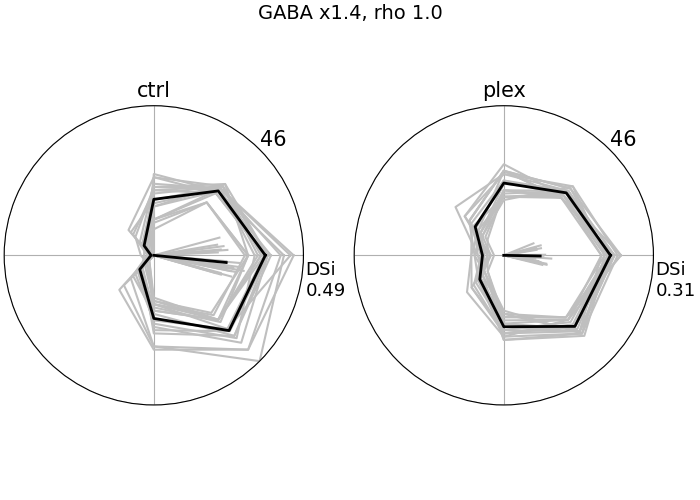

In [7]:
rho = 1.
factor = 1.4

max_spikes = np.max([r["spikes"] for ms in metrics.values() for r in ms[factor].values()])
focus_polar_fig = plt.figure(figsize=(7, 5))
n_cols = len(rhos)
focus_polar_ax = [
    polar_plot(
        m[factor][rho],
        dir_labels,
        title=exp,
        radius=max_spikes,
        net_shadows=False,
        save=False,
        fig=focus_polar_fig,
        sub_loc=(1, n_cols, loc + 1),
        title_metrics=False,
    )
    for loc, (exp, m) in enumerate(metrics.items())
]
focus_polar_fig.suptitle("GABA x%.1f, rho %.1f" % (factor, rho), fontsize=14)
focus_polar_fig.set_layout_engine("compressed")
focus_polar_fig.savefig(
    os.path.join(fig_path, "gaba_x%.1f_rho%.1f_polars.png" % (factor, rho)), bbox_inches="tight")

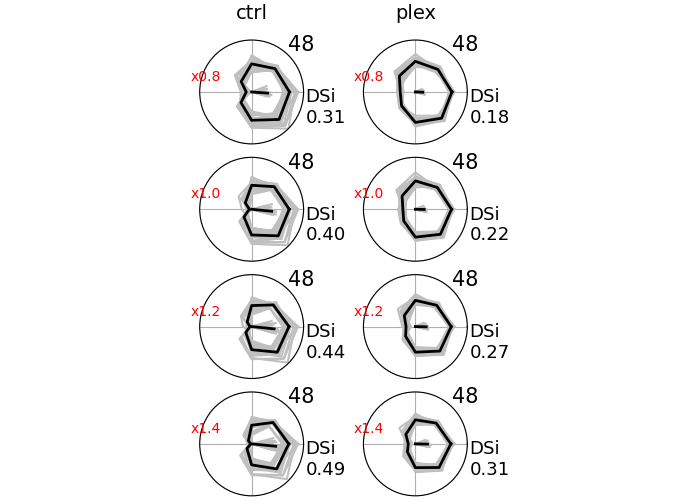

In [8]:
rho = 1.0
display_factors = factors
# display_factors = [0.4, 0.6, 0.8, 1.0]
display_factors = [0.8, 1.0, 1.2, 1.4]
# display_factors = [0.1, 0.2, 0.4, 0.6]

max_spikes = np.max([r["spikes"] for m in metrics.values() for s in display_factors for r in m[s].values()])
polar_fig = plt.figure(figsize=(7, 5))
max_rows = 5
n_rows = min(max_rows, len(display_factors))
splits = int(np.ceil(len(display_factors) / max_rows))
n_cols = len(rhos) * splits
polar_ax = []
for i, factor in enumerate(display_factors):
    row = i % max_rows
    subcol = i // max_rows
    for j, (exp, m) in enumerate(metrics.items()):
        polar_ax.append(polar_plot(
            m[factor][rho],
            dir_labels,
            title=None,
            title_metrics=False,
            radius=max_spikes,
            net_shadows=False,
            save=False,
            fig=polar_fig,
            sub_loc=(n_rows, n_cols, (row * n_cols + j * splits + subcol + 1)),
            dsi_tag_deg=-30,
            dsi_tag_mult=1.2,
        ))
        polar_ax[-1].text(np.radians(170), max_spikes * 1.2, ("x" + str(factor)), c="red")

for i in range(len(exps)):
    polar_ax[i].set_title(exps[i], fontsize=14, pad=15)

polar_fig.set_layout_engine("compressed")
lbl = "many" if len(display_factors) > 4 else "_".join(map(str, display_factors)).replace(".", "p")
for ext in [".png", ".svg"]:
    polar_fig.savefig(os.path.join(fig_path, "polar_grid_%s%s" % (lbl, ext)), bbox_inches="tight")

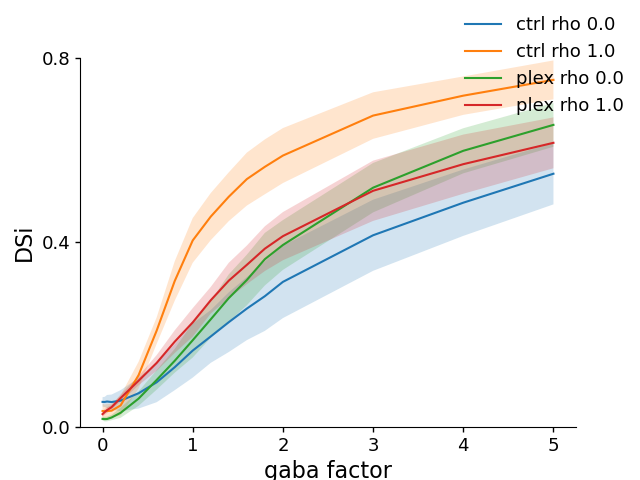

In [9]:
display_exps = exps
# display_exps = [ctrl_lbl]
display_rhos = rhos
# display_rhos = [1.0]

dsi_fig, dsi_ax = plt.subplots(1)
titration_dsis = {}
for exp in display_exps:
    titration_dsis[exp] = {}
    for rho in display_rhos:
        titration_dsis[exp][rho] = {"nets": [], "avg": [], "std": []}
        for factor in factors:
            dsis = metrics[exp][factor][rho]["DSis"]
            dsi_net_avgs = metrics[exp][factor][rho]["DSis"].mean(axis=1)
            titration_dsis[exp][rho]["nets"].append(dsi_net_avgs)
            titration_dsis[exp][rho]["avg"].append(np.mean(dsi_net_avgs))
            titration_dsis[exp][rho]["std"].append(np.std(dsi_net_avgs))
        titration_dsis[exp][rho] = {m: np.array(v) for m, v in titration_dsis[exp][rho].items()}
        titration_dsis[exp][rho]["nets"] = titration_dsis[exp][rho]["nets"].T
        dsi_ax.fill_between(
            factors, 
            titration_dsis[exp][rho]["avg"] + titration_dsis[exp][rho]["std"],
            titration_dsis[exp][rho]["avg"] - titration_dsis[exp][rho]["std"],
            alpha=0.2
        )
        dsi_ax.plot(factors, titration_dsis[exp][rho]["avg"], label="%s rho %s" % (exp, str(rho)))
        
dsi_ax.set_ylabel("DSi", fontsize=16)
dsi_ax.set_xlabel("gaba factor", fontsize=16)
# dsi_ax.set_xscale("log")
dsi_ax.set_ylim(0, 0.8)
dsi_ax.set_yticks([0, 0.4, 0.8])

dsi_fig.legend(frameon=False, fontsize=13)
clean_axes(dsi_ax, ticksize=13)
exps_lbl = "_".join(display_exps)
rhos_lbl = "_".join(map(str, display_rhos)).replace(".", "p")
for ext in [".png", ".svg"]:
    dsi_fig.savefig(
        os.path.join(fig_path, "dsi_vs_gaba_factor_%s_rhos_%s%s" % (exps_lbl, rhos_lbl, ext)),
        bbox_inches="tight",
    )

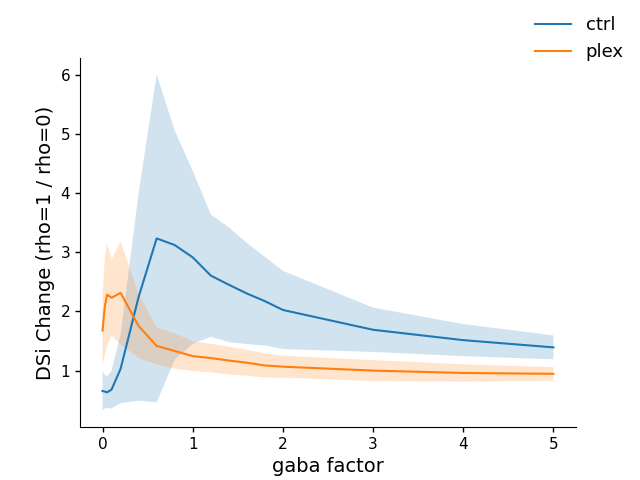

In [10]:
rho_dsi_effect_fig, rho_dsi_effect_ax = plt.subplots(1)
rho_dsi_effect_nets = {exp: dsis[1.0]["nets"] / dsis[0.0]["nets"] for exp, dsis in titration_dsis.items()}
rho_dsi_effect_avg = {exp: np.mean(nets, axis=0) for exp, nets in rho_dsi_effect_nets.items()}
rho_dsi_effect_std = {exp: np.std(nets, axis=0) for exp, nets in rho_dsi_effect_nets.items()}

for exp in exps:
    rho_dsi_effect_ax.fill_between(
        factors, 
        rho_dsi_effect_avg[exp] + rho_dsi_effect_std[exp],
        rho_dsi_effect_avg[exp] - rho_dsi_effect_std[exp],
        alpha=0.2
    )
    rho_dsi_effect_ax.plot(factors, rho_dsi_effect_avg[exp], label=exp)

rho_dsi_effect_ax.set_ylabel("DSi Change (rho=1 / rho=0)", fontsize=14)
rho_dsi_effect_ax.set_xlabel("gaba factor", fontsize=14)
# rho_dsi_effect_ax.set_xscale("log")
rho_dsi_effect_fig.legend(frameon=False, fontsize=13)

clean_axes(rho_dsi_effect_ax)
rho_dsi_effect_fig.savefig(os.path.join(fig_path, "dsi_effect_of_rho.png"), bbox_inches="tight")

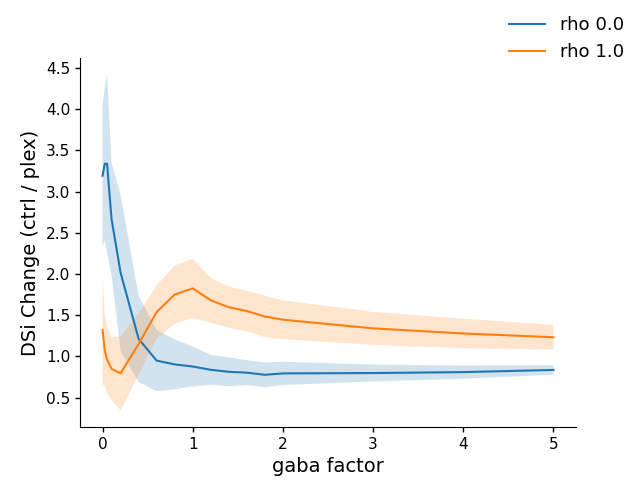

In [11]:
display_rhos = rhos
# display_rhos = [1.0]

exp_dsi_effect_fig, exp_dsi_effect_ax = plt.subplots(1)
exp_dsi_effect_nets = {
    rho: titration_dsis[ctrl_lbl][rho]["nets"] / titration_dsis[expr_lbl][rho]["nets"] 
    for rho in rhos
}
exp_dsi_effect_avg = {rho: np.mean(nets, axis=0) for rho, nets in exp_dsi_effect_nets.items()}
exp_dsi_effect_std = {rho: np.std(nets, axis=0) for rho, nets in exp_dsi_effect_nets.items()}

for rho in display_rhos:
    exp_dsi_effect_ax.fill_between(
        factors, 
        exp_dsi_effect_avg[rho] + exp_dsi_effect_std[rho],
        exp_dsi_effect_avg[rho] - exp_dsi_effect_std[rho],
        alpha=0.2
    )
    exp_dsi_effect_ax.plot(factors, exp_dsi_effect_avg[rho], label="rho " + str(rho))

exp_dsi_effect_ax.set_ylabel("DSi Change (%s / %s)" % (ctrl_lbl, expr_lbl), fontsize=14)
exp_dsi_effect_ax.set_xlabel("gaba factor", fontsize=14)
# exp_dsi_effect_ax.set_xscale("log")
exp_dsi_effect_fig.legend(frameon=False, fontsize=13)

clean_axes(exp_dsi_effect_ax)
exp_dsi_effect_fig.savefig(os.path.join(fig_path, "dsi_effect_of_exp.png"), bbox_inches="tight")

In [12]:
avg_spikes = {
    exp: {
        fac: {rho: np.mean(nets["spikes"], axis=(0, 1)) for rho, nets in rs.items()}
        for fac, rs in ms.items()
    }
    for exp, ms in metrics.items()
}
std_spikes = {
    exp: {
        fac: {rho: np.std(nets["spikes"], axis=(0, 1)) for rho, nets in rs.items()}
        for fac, rs in ms.items()
    }
    for exp, ms in metrics.items()
}

wrap_circ = lambda ds: np.concatenate((ds, [ds[0]]))
dirs_180 = np.array([ana.scale_180_from_360(d) for d in  dir_labels])
dir_sort = np.argsort(dirs_180)
dirs_sorted = dir_labels[dir_sort]
dirs_180_sorted = dirs_180[dir_sort]
circ_180 = np.concatenate((dirs_180_sorted, [-dirs_180_sorted[0]]))

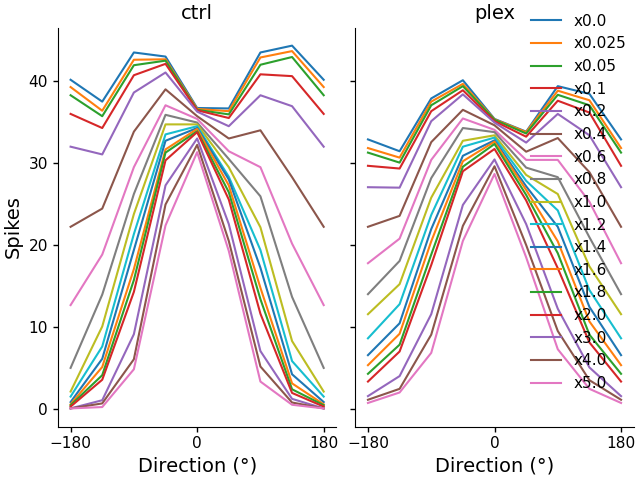

In [13]:
rho = 1.0

tuning_fig, tuning_ax = plt.subplots(1, len(rhos), sharey=True)
for i, (ax, exp) in enumerate(zip(tuning_ax, exps)):
    ax.set_xlabel("Direction (°)", fontsize=14)
    ax.set_title(exp, fontsize=14)
    for factor in factors:
        lbl = ("x" + str(factor)) if not i else None
        ax.plot(circ_180, wrap_circ(avg_spikes[exp][factor][rho][dir_sort]), label=lbl)
    ax.set_xticks([-180, 0, 180])
tuning_ax[0].set_ylabel("Spikes", fontsize=14)
tuning_fig.legend(frameon=False, fontsize=11)
clean_axes(tuning_ax)
tuning_fig.set_layout_engine("compressed")
tuning_fig.savefig(os.path.join(fig_path, "tuning.png"), bbox_inches="tight")

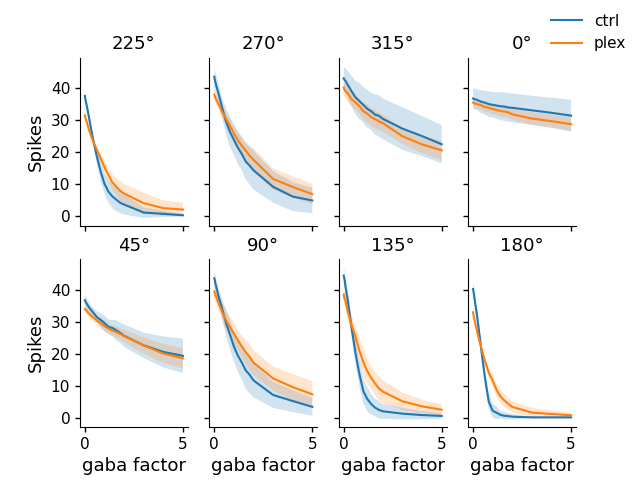

In [14]:
rho = 1.0
dir_grid_fig, dir_grid_ax = plt.subplots(2, 4, sharex=True, sharey=True)

i = 0
for row in dir_grid_ax:
    row[0].set_ylabel("Spikes", fontsize=13)
    for ax in row:
        for exp in exps:
            spks = np.array([avg_spikes[exp][factor][rho][i] for factor in factors])
            stds = np.array([std_spikes[exp][factor][rho][i] for factor in factors])
            lbl = exp if not i else None
            ax.fill_between(factors, spks + stds, spks - stds, alpha=0.2)
            ax.plot(factors, spks, label=lbl)
            ax.set_title("%i°" % dir_labels[i], fontsize=13)
        i += 1

for col in dir_grid_ax.T:
    col[-1].set_xlabel("gaba factor", fontsize=13)

# dir_grid_ax[0, 0].invert_xaxis()
# dir_grid_ax[0, 0].set_xscale("log")
dir_grid_fig.legend(frameon=False, fontsize=11)
clean_axes(dir_grid_ax)
dir_grid_fig.savefig(os.path.join(fig_path, "dir_spikes_grid.png"), bbox_inches="tight")

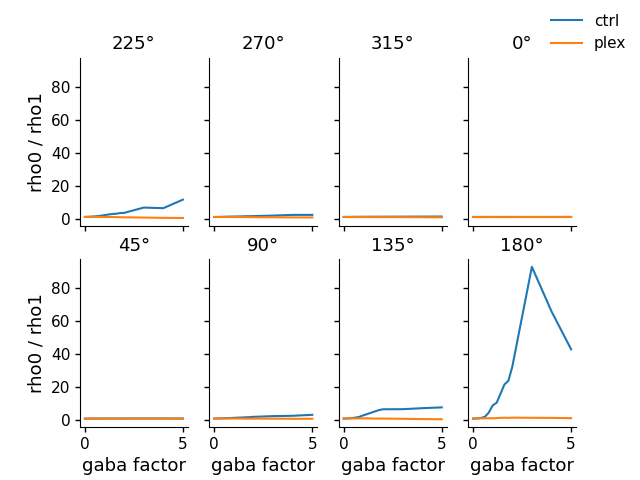

In [15]:
dir_rho_mult_grid_fig, dir_rho_mult_grid_ax = plt.subplots(2, 4, sharex=True, sharey=True)

i = 0
for row in dir_rho_mult_grid_ax:
    row[0].set_ylabel("rho0 / rho1", fontsize=13)
    for ax in row:
        for exp in exps:
            rho0_spks = np.array([avg_spikes[exp][factor][0.0][i] for factor in factors])
            rho1_spks = np.array([avg_spikes[exp][factor][1.0][i] for factor in factors])
            lbl = exp if not i else None
            ax.plot(factors, rho0_spks / rho1_spks, label=lbl)
            ax.set_title("%i°" % dir_labels[i], fontsize=13)
        i += 1

for col in dir_rho_mult_grid_ax.T:
    col[-1].set_xlabel("gaba factor", fontsize=13)
        
dir_rho_mult_grid_fig.legend(frameon=False, fontsize=11)
clean_axes(dir_rho_mult_grid_ax)
dir_rho_mult_grid_fig.savefig(os.path.join(fig_path, "dir_spikes_effect_of_rho_grid.png"), bbox_inches="tight")

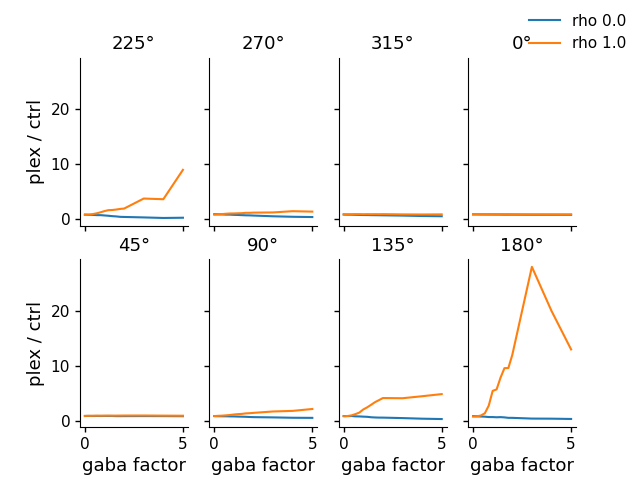

In [16]:
dir_exp_mult_grid_fig, dir_exp_mult_grid_ax = plt.subplots(2, 4, sharex=True, sharey=True)

i = 0
for row in dir_exp_mult_grid_ax:
    row[0].set_ylabel("%s / %s" % (expr_lbl, ctrl_lbl), fontsize=13)
    for ax in row:
        for rho in rhos:
            ctrl_spks = np.array([avg_spikes[ctrl_lbl][factor][rho][i] for factor in factors])
            expr_spks = np.array([avg_spikes[expr_lbl][factor][rho][i] for factor in factors])
            lbl = ("rho " + str(rho)) if not i else None
            ax.plot(factors, expr_spks / ctrl_spks, label=lbl)
            ax.set_title("%i°" % dir_labels[i], fontsize=13)
        i += 1

for col in dir_exp_mult_grid_ax.T:
    col[-1].set_xlabel("gaba factor", fontsize=13)
        
dir_exp_mult_grid_fig.legend(frameon=False, fontsize=11)
clean_axes(dir_exp_mult_grid_ax)
dir_exp_mult_grid_fig.savefig(os.path.join(fig_path, "dir_spikes_effect_of_exp_grid.png"), bbox_inches="tight")

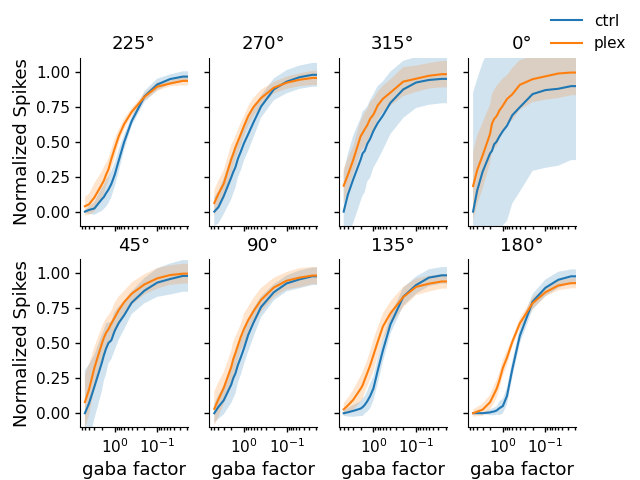

In [17]:
rho = 1.0
norm_dir_grid_fig, norm_dir_grid_ax = plt.subplots(2, 4, sharex=True, sharey=True)

norm_dir_spikes, norm_dir_stds = {}, {}
for exp in exps:
    norm_dir_spikes[exp] = []
    norm_dir_stds[exp] = []
    for i in range(len(dir_labels)):
        spks = np.stack([[avg_spikes[exp][factor][rho][i] for factor in factors] for rho in rhos], axis=0)
        stds = np.stack([[std_spikes[exp][factor][rho][i] for factor in factors] for rho in rhos], axis=0)
        min_spks = np.min(spks)
        max_spks = np.max(spks)
        spks = (spks - min_spks) / (max_spks - min_spks)
        stds = stds / (max_spks - min_spks)
        norm_dir_spikes[exp].append(spks)
        norm_dir_stds[exp].append(stds)
norm_dir_spikes = {exp: np.stack(spks, axis=0) for exp, spks in norm_dir_spikes.items()}
norm_dir_stds = {exp: np.stack(stds, axis=0) for exp, stds in norm_dir_stds.items()}
    
i = 0
j = np.argwhere(np.array(rhos) == rho)[0][0]
for row in norm_dir_grid_ax:
    row[0].set_ylabel("Normalized Spikes", fontsize=13)
    for ax in row:
        for exp in exps:
            lbl = exp if not i else None
            spks = norm_dir_spikes[exp][i, j]
            stds = norm_dir_stds[exp][i, j]
            ax.fill_between(factors, spks + stds, spks - stds, alpha=0.2)
            ax.plot(factors, spks, label=lbl)
            ax.set_title("%i°" % dir_labels[i], fontsize=13)
        i += 1

for col in norm_dir_grid_ax.T:
    col[-1].set_xlabel("gaba factor", fontsize=13)
        
norm_dir_grid_ax[0, 0].set_ylim(-0.1, 1.1)
norm_dir_grid_ax[0, 0].invert_xaxis()
norm_dir_grid_ax[0, 0].set_xscale("log")
norm_dir_grid_fig.legend(frameon=False, fontsize=11)
clean_axes(norm_dir_grid_ax)
norm_dir_grid_fig.savefig(os.path.join(fig_path, "norm_dir_spikes_grid.png"), bbox_inches="tight")

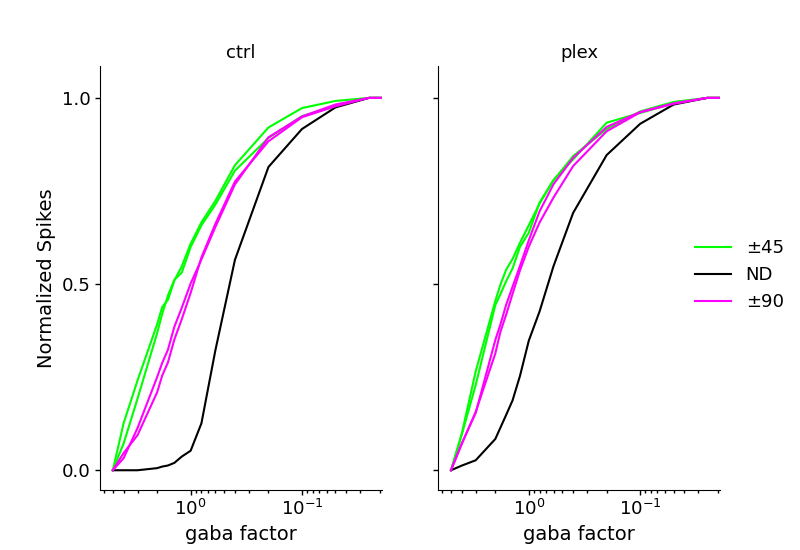

In [18]:
rho = 1.0
fctrs = factors[:]
# fctrs = factors[4:]
norm_rho_dir_spikes, norm_rho_dir_stds = {}, {}
for exp in exps:
    norm_rho_dir_spikes[exp] = []
    norm_rho_dir_stds[exp] = []
    for i in range(len(dir_labels)):
        spks = np.stack([[avg_spikes[exp][factor][rho][i] for factor in fctrs] for rho in rhos], axis=0)
        stds = np.stack([[std_spikes[exp][factor][rho][i] for factor in fctrs] for rho in rhos], axis=0)
        # if gaba factor x0.0 is included, lines will not reach spiking=1 on the log plot
        min_spks = np.min(spks[:, 1:], axis=1, keepdims=True) 
        max_spks = np.max(spks[:, 1:], axis=1, keepdims=True)
        spks = (spks - min_spks) / (max_spks - min_spks)
        stds = stds / (max_spks - min_spks)
        norm_rho_dir_spikes[exp].append(spks)
        norm_rho_dir_stds[exp].append(stds)
norm_rho_dir_spikes = {exp: np.stack(spks, axis=0) for exp, spks in norm_rho_dir_spikes.items()}
norm_rho_dir_stds = {exp: np.stack(stds, axis=0) for exp, spks in norm_rho_dir_stds.items()}

r = np.argwhere(np.array(rhos) == rho)[0][0]
log_titration_fig, log_titration_ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(8, 5.5))
for i, (exp, ax) in enumerate(zip(exps, log_titration_ax)):
    ax.plot(fctrs, norm_rho_dir_spikes[exp][2, r], label="±45" if i else None, c="lime")  # 45
    ax.plot(fctrs, norm_rho_dir_spikes[exp][4, r], c="lime")  # 315
    # ax.fill_between(
    #     fctrs, 
    #     norm_rho_dir_spikes[exp][7, r] + norm_rho_dir_stds[exp][7, r],
    #     norm_rho_dir_spikes[exp][7, r] - norm_rho_dir_stds[exp][7, r],
    #     alpha=0.2, color="black"
    # )
    ax.plot(fctrs, norm_rho_dir_spikes[exp][7, r], label="ND" if i else None, c="black")  # 180
    ax.plot(fctrs, norm_rho_dir_spikes[exp][1, r], label="±90" if i else None, c="magenta")  # 270
    ax.plot(fctrs, norm_rho_dir_spikes[exp][5, r], c="magenta")  # 90
    ax.set_title(exp, fontsize=13)
    ax.set_xlabel("gaba factor", fontsize=14)

# from matplotlib.scale import LogScale
log_titration_ax[0].set_yticks([0, 0.5, 1.0])
log_titration_ax[0].set_ylabel("Normalized Spikes", fontsize=14)
log_titration_ax[0].invert_xaxis()
log_titration_ax[0].set_xscale("log")
log_titration_fig.legend(frameon=False, loc="right", fontsize=13)
clean_axes(log_titration_ax, ticksize=13)
log_titration_fig.savefig(os.path.join(fig_path, "log_titration.png"), bbox_inches="tight")

In [19]:
avg_spike_mats = {
    exp: {
        rho: np.stack(
            [wrap_circ(avg_spikes[exp][factor][rho][dir_sort]) for factor in factors], axis=0)
        for rho in rhos
    }
    for exp in exps
}
avg_max_spikes = np.max([m.max() for mats in avg_spike_mats.values() for m in mats.values()])

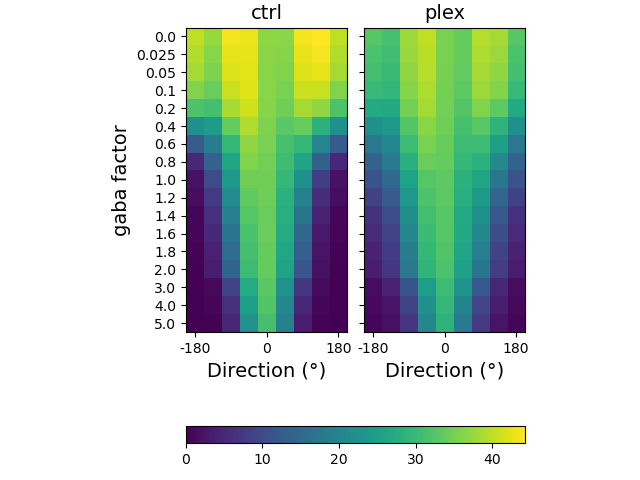

In [20]:
rho = 1.0
vmax = avg_max_spikes
# vmax = 20.0

tuning_mat_fig, tuning_mat_ax = plt.subplots(1, 2, sharey=True)
avg_spike_imgs = {}
for i, (ax, exp) in enumerate(zip(tuning_mat_ax, exps)):
    ax.set_xlabel("Direction (°)", fontsize=14)
    ax.set_title(exp, fontsize=14)
    avg_spike_imgs[exp] = ax.imshow(avg_spike_mats[exp][rho], vmin=0, vmax=vmax, cmap="viridis")
    ax.set_xticks([0, 4, 8])
    ax.set_xticklabels([-180, 0, 180])
    ax.set_yticks(range(len(factors)))
    ax.set_yticklabels(factors)
    
tuning_mat_ax[0].set_ylabel("gaba factor", fontsize=14)
tuning_mat_fig.colorbar(
    avg_spike_imgs[exps[-1]], ax=tuning_mat_ax, orientation="horizontal")
tuning_mat_fig.set_layout_engine("compressed")
tuning_mat_fig.savefig(os.path.join(fig_path, "tuning_matrices.png"), bbox_inches="tight")

In [21]:
close_button()